# Emotion Recognition with Face Images

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
train_path = 'images/train/'
val_path = 'images/validation/'

## Loading training data

In [3]:
os.listdir(val_path)

['happy', 'sad', 'fear', 'surprise', 'neutral']

In [4]:
# Loading training data
image = []
labels = []
for class_idx, class_name in enumerate(os.listdir(train_path)):
    print(class_name, class_idx)
    class_folder = os.path.join(train_path, class_name)
    for img_file in os.listdir(class_folder):
        img = cv2.imread(os.path.join(class_folder, img_file))
        img = cv2.resize(img, (48, 48))
        image.append(img)
        labels.append(class_idx)

image = np.array(image)
labels = np.array(labels)

happy 0
sad 1
fear 2
surprise 3
neutral 4


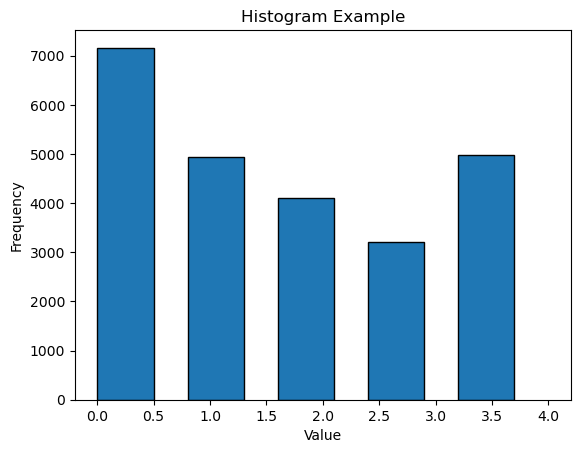

In [5]:
plt.hist(labels, width= 0.5, bins=5, edgecolor='black')  # bins는 막대 개수를 조절
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Loading validation data
x_val = []
y_val = []
for class_idx, class_name in enumerate(os.listdir(val_path)):
    class_folder = os.path.join(val_path, class_name)
    for img_file in os.listdir(class_folder):
        img = cv2.imread(os.path.join(class_folder, img_file))
        img = cv2.resize(img, (48, 48))
        x_val.append(img)
        y_val.append(class_idx)

x_val = np.array(x_val)
y_val = np.array(y_val)

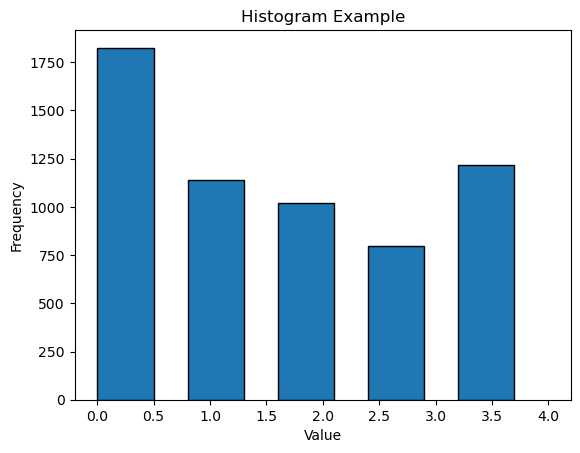

In [7]:
plt.hist(y_val, width= 0.5, bins=5, edgecolor='black')  # bins는 막대 개수를 조절
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [8]:
labels_tensor = torch.tensor(labels, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [9]:
# Convert numpy arrays to PyTorch tensors
images_tensor = torch.tensor(image, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0

## Model Architecture

In [10]:
from torch.quantization import QuantStub, DeQuantStub

class EmotionRecognitionModel(nn.Module):
    def __init__(self, num_classes=5):
        super(EmotionRecognitionModel, self).__init__()
        self.quant = QuantStub()  # Quantization module
        self.dequant = DeQuantStub()  # Dequantization module
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=1, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.quant(x)  # Quantize input
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dequant(x)  # Dequantize output
        return x
model = EmotionRecognitionModel().to('mps')

In [11]:
# Model parameters
num_classes = 5
input_shape = (48, 48, 3)

# Instantiate the model
#model = EmotionRecognitionModel(num_classes=num_classes).to('mps')

# Compile the model (PyTorch equivalent)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0009, weight_decay=0.01)

# Create DataLoader
train_dataset = TensorDataset(images_tensor, labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

## Training the Model

In [12]:
# Training loop with train accuracy calculation
epochs = 200
patience = 25
best_val_acc = 0
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.to('mps')).to('mps')
        loss = criterion(outputs.to('mps'), labels.to('mps'))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Training accuracy calculation
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train.to('mps') == labels.to('mps')).sum().item()

    train_acc = correct_train / total_train  # Train accuracy for this epoch

    # Validation step
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs.to('mps'))
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val.to('mps') == labels.to('mps')).sum().item()

    val_acc = correct_val / total_val  # Validation accuracy for this epoch

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'MyModelFaceRecogD3.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Epoch [1/200], Loss: 1.5502, Train Accuracy: 0.2989, Test Accuracy: 0.3264
Epoch [2/200], Loss: 1.3967, Train Accuracy: 0.4028, Test Accuracy: 0.4609
Epoch [3/200], Loss: 1.2741, Train Accuracy: 0.4710, Test Accuracy: 0.5026
Epoch [4/200], Loss: 1.1986, Train Accuracy: 0.5087, Test Accuracy: 0.5406
Epoch [5/200], Loss: 1.1422, Train Accuracy: 0.5340, Test Accuracy: 0.5680
Epoch [6/200], Loss: 1.1007, Train Accuracy: 0.5529, Test Accuracy: 0.5863
Epoch [7/200], Loss: 1.0630, Train Accuracy: 0.5702, Test Accuracy: 0.5731
Epoch [8/200], Loss: 1.0395, Train Accuracy: 0.5784, Test Accuracy: 0.5982
Epoch [9/200], Loss: 1.0191, Train Accuracy: 0.5897, Test Accuracy: 0.5973
Epoch [10/200], Loss: 0.9949, Train Accuracy: 0.5999, Test Accuracy: 0.6115
Epoch [11/200], Loss: 0.9752, Train Accuracy: 0.6044, Test Accuracy: 0.6148
Epoch [12/200], Loss: 0.9573, Train Accuracy: 0.6139, Test Accuracy: 0.6145
Epoch [13/200], Loss: 0.9458, Train Accuracy: 0.6207, Test Accuracy: 0.6344
Epoch [14/200], Loss:

In [12]:
model.load_state_dict(torch.load('MyModelFaceRecogD3.pth'))

<All keys matched successfully>

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

2,602,181 total parameters.


In [14]:
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

# No prune

In [15]:
import time
model.load_state_dict(torch.load('MyModelFaceRecogD3.pth'))
model.to('mps')

model.eval()
correct_val = 0
total_val = 0
model.to('mps')
start_time = time.time()

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs.to('mps'))
        _, predicted_val = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val.to('mps') == labels.to('mps')).sum().item()
        
    total_inference_time = 0.0
    for _ in range(100):
        start_time = time.time()
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.to('mps'))
        end_time = time.time()
        total_inference_time += (end_time - start_time)

    average_inference_time = total_inference_time / 100
    val_acc = correct_val / total_val  # Validation accuracy for this epoch
    end_time = time.time()
    print(val_acc)
    
    runtime = end_time - start_time
    print(f'Prediction Runtime: {average_inference_time:.2f} seconds')
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    print_model_size(model)



0.6752293577981652
Prediction Runtime: 0.19 seconds
2,602,181 total parameters.
10.41 MB


### Quantization

In [16]:
model.to('cpu')
backend = "qnnpack"
model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend
model_static_quantized = torch.quantization.prepare(model, inplace=False)
model_static_quantized = torch.quantization.convert(model_static_quantized, inplace=False)

import os
import torch

def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')
print_model_size(model_static_quantized)
print_model_size(model)

2.61 MB
10.41 MB


In [17]:
import time
model_static_quantized.to('cpu')
model_static_quantized.eval()
correct_val = 0
total_val = 0

start_time = time.time()

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model_static_quantized(inputs.to('cpu'))
        _, predicted_val = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val.to('cpu') == labels.to('cpu')).sum().item()
    
    val_acc = correct_val / total_val  # Validation accuracy for this epoch
    end_time = time.time()
    print(val_acc)
    
    runtime = end_time - start_time
    print(f'Prediction Runtime: {runtime:.2f} seconds')
    total_params = sum(p.numel() for p in model_static_quantized.parameters())
    print(f'{total_params:,} total parameters.')
    print_model_size(model_static_quantized)

0.3474562135112594
Prediction Runtime: 1.71 seconds
0 total parameters.
2.61 MB


In [18]:
import time
model.to('cpu')
model.eval()
correct_val = 0
total_val = 0

start_time = time.time()

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs.to('cpu'))
        _, predicted_val = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val.to('cpu') == labels.to('cpu')).sum().item()
    
    val_acc = correct_val / total_val  # Validation accuracy for this epoch
    end_time = time.time()
    print(val_acc)
    
    runtime = end_time - start_time
    print(f'Prediction Runtime: {runtime:.2f} seconds')
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    print_model_size(model)

0.6752293577981652
Prediction Runtime: 2.92 seconds
2,602,181 total parameters.
10.41 MB


In [19]:
import torch
import os
import time
import torch_pruning as tp
from ptflops import get_model_complexity_info

model.to('cpu')
# Dynamic quantization
model_dynamic_quantized = torch.quantization.quantize_dynamic(
    model,  # Pass the pre-trained model here
    {torch.nn.Linear},  # Specify layers to quantize (e.g., Linear layers)
    dtype=torch.qint8  # Use 8-bit integers for weights
)

# Function to calculate model size
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" % (os.path.getsize("tmp.pt") / 1e6))
    os.remove('tmp.pt')

# Print sizes of original and quantized models
print_model_size(model_dynamic_quantized)
print_model_size(model)

# Validation Accuracy and Runtime
model_dynamic_quantized.to('cpu')
model_dynamic_quantized.eval()

correct_val = 0
total_val = 0

start_time = time.time()

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model_dynamic_quantized(inputs.to('cpu'))
        _, predicted_val = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val.to('cpu') == labels.to('cpu')).sum().item()

    val_acc = correct_val / total_val  # Validation accuracy for this epoch
    end_time = time.time()
    print(val_acc)

    runtime = end_time - start_time
    print(f'Prediction Runtime: {runtime:.2f} seconds')
    total_params = sum(p.numel() for p in model_dynamic_quantized.parameters())
    print(f'{total_params:,} total parameters.')
    print_model_size(model_dynamic_quantized)
    example_inputs = torch.randn(1,3, 48, 48)
    prune_macs, prune_nparams = tp.utils.count_ops_and_params(model_dynamic_quantized.to('cpu'), example_inputs.to('cpu'))
    print(f'\tMACs: {prune_macs / 1e6} M')
    print(f'\tParams: {prune_nparams / 1e6} M')
    flops, params = get_model_complexity_info(model_dynamic_quantized, (3,48,48), as_strings=True, print_per_layer_stat=True)
    print("flops : ", flops)


2.94 MB
10.41 MB


[W1204 05:51:48.831806000 qlinear_dynamic.cpp:251] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


0.6763969974979149
Prediction Runtime: 2.89 seconds
109,760 total parameters.
2.94 MB
	MACs: 24.0768 M
	Params: 0.10976 M
EmotionRecognitionModel(
  109.76 k, 100.000% Params, 24.08 MMac, 98.918% MACs, 
  (quant): QuantStub(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  (dequant): DeQuantStub(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  (conv1): Conv2d(896, 0.816% Params, 2.06 MMac, 8.481% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(18.5 k, 16.851% Params, 10.65 MMac, 43.770% MACs, 32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(73.86 k, 67.289% Params, 10.64 MMac, 43.694% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16.51 k, 15.044% Params, 594.43 KMac, 2.442% MACs, 128, 128, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(0, 0.000% Params, 129.02 KMac, 0.530% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(0, 0.000% Params, 0.0 Mac, 

In [20]:
correct_val = 0
total_val = 0

start_time = time.time()

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model_dynamic_quantized(inputs.to('cpu'))
        _, predicted_val = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val.to('cpu') == labels.to('cpu')).sum().item()

    val_acc = correct_val / total_val  # Validation accuracy for this epoch
    end_time = time.time()
    print(val_acc)

    runtime = end_time - start_time
    print(f'Prediction Runtime: {runtime:.2f} seconds')
    total_params = sum(p.numel() for p in model_dynamic_quantized.parameters())
    print(f'{total_params:,} total parameters.')
    print_model_size(model_dynamic_quantized)
    example_inputs = torch.randn(1,3, 48, 48)
    prune_macs, prune_nparams = tp.utils.count_ops_and_params(model_dynamic_quantized.to('cpu'), example_inputs.to('cpu'))
    print(f'\tMACs: {prune_macs / 1e6} M')
    print(f'\tParams: {prune_nparams / 1e6} M')
    flops, params = get_model_complexity_info(model_dynamic_quantized, (3,48,48), as_strings=True, print_per_layer_stat=True)
    print("flops : ", flops)

0.6763969974979149
Prediction Runtime: 2.75 seconds
109,760 total parameters.
2.94 MB
	MACs: 24.0768 M
	Params: 0.10976 M
Flops estimation was not finished successfully because of the following exception:
<class 'RuntimeError'> : In ChooseQuantizationParams, min should be less than or equal to max
flops :  None


Traceback (most recent call last):
  File "/Users/suwanive/anaconda3/lib/python3.11/site-packages/ptflops/pytorch_engine.py", line 68, in get_flops_pytorch
    _ = flops_model(batch)
        ^^^^^^^^^^^^^^^^^^
  File "/Users/suwanive/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/suwanive/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1844, in _call_impl
    return inner()
           ^^^^^^^
  File "/Users/suwanive/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1790, in inner
    result = forward_call(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/18/ymgptbyd57d77mtztx7d3d2w0000gn/T/ipykernel_56895/359158781.py", line 32, in forward
    x = F.relu(self.fc1(x))
               ^^^^^^^^^^^
  File "/Users/suwanive/anaconda3/lib/python3.11/site-package